In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed(0)
np.set_printoptions(precision=2)

In [2]:
def pretty_print_linear(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) for coef, name in lst)

In [3]:
def root_mean_square_error(y_pred,y_test):
    rmse_train = np.sqrt(np.dot(abs(y_pred-y_test),abs(y_pred-y_test))/len(y_test))
    return rmse_train

In [4]:
def ohc_conversion(input_text):
    if "ohc" in input_text:
        return 1
    else:
        return 0

In [5]:
def plot_real_vs_predicted(y_pred,y_test):
    plt.plot(y_pred,y_test,'ro')
    plt.plot([0,50],[0,50], 'g-')
    plt.xlabel('predicted')
    plt.ylabel('real')
    plt.show()
    return plt

### Reading the csv file 

In [6]:
df = pd.read_csv('CarPrice_Assignment.csv')

### Viewing the 1st 5 rows of the dataframe

In [7]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [8]:
print "Number of rows in dataset = ", df.shape[0]
print "Number of features in dataset = ", df.shape[1]

Number of rows in dataset =  205
Number of features in dataset =  26


In [9]:
df.drop('car_ID',axis=1, inplace=True)

### Number of null values in the dataframe - 

In [10]:
df.isnull().sum()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

### Plausability check of numeric values

In [11]:
df.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


### Checking values of categorical variables

In [12]:
categorical_columns = list(df.select_dtypes(['object']).columns)

In [13]:
for cols in categorical_columns:
    print ([cols], " : ", df[cols].unique())

(['CarName'], ' : ', array(['alfa-romero giulia', 'alfa-romero stelvio',
       'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls', 'audi fox',
       'audi 5000', 'audi 4000', 'audi 5000s (diesel)', 'bmw 320i',
       'bmw x1', 'bmw x3', 'bmw z4', 'bmw x4', 'bmw x5',
       'chevrolet impala', 'chevrolet monte carlo', 'chevrolet vega 2300',
       'dodge rampage', 'dodge challenger se', 'dodge d200',
       'dodge monaco (sw)', 'dodge colt hardtop', 'dodge colt (sw)',
       'dodge coronet custom', 'dodge dart custom',
       'dodge coronet custom (sw)', 'honda civic', 'honda civic cvcc',
       'honda accord cvcc', 'honda accord lx', 'honda civic 1500 gl',
       'honda accord', 'honda civic 1300', 'honda prelude',
       'honda civic (auto)', 'isuzu MU-X', 'isuzu D-Max ',
       'isuzu D-Max V-Cross', 'jaguar xj', 'jaguar xf', 'jaguar xk',
       'maxda rx3', 'maxda glc deluxe', 'mazda rx2 coupe', 'mazda rx-4',
       'mazda glc deluxe', 'mazda 626', 'mazda glc', 'mazda rx-7 gs

In [14]:
len(df.CarName.unique())

147

### 147 different car models would give rise to 147 different columns when they are one-hot encoded.
We can group different car models based on their 1st name & since the count of porsche, isuzu, jaguar, alfa-romero, chevrolet, vw, renault etc are less than 6 we can combine it into others category

In [15]:
def car_type(input_text):
    other_cars = set(['porsche', 'isuzu', 'jaguar', 'alfa-romero', 'chevrolet',
              'vw', 'renault','maxda','mercury', 'Nissan', 'toyouta',
              'vokswagen', 'porcshce'])
    if (len(input_text.split(' '))>1) and (input_text.split(' ')[0] not in other_cars):
        return input_text.split(' ')[0]
    else:
        return 'others'

In [16]:
df.CarName.apply(car_type).value_counts()

toyota        31
others        30
nissan        17
mazda         15
mitsubishi    13
honda         13
peugeot       11
volvo         11
subaru        10
volkswagen     9
dodge          9
bmw            8
buick          8
audi           7
plymouth       7
saab           6
Name: CarName, dtype: int64

In [17]:
df.CarName = df.CarName.apply(car_type)

In [18]:
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,others,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,others,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,others,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [19]:
word2num_mapping = {'one': 1,'two':2,'three':3,'four':4, 'five':5, 'six':6, 'seven':7,
                    'eight':8, 'nine':9, 'twelve':12}

### Converting categorical variables to numeric

In [20]:
df.doornumber.replace(word2num_mapping,inplace=True)
df.doornumber = df.doornumber.astype(int)

In [21]:
df.cylindernumber.replace(word2num_mapping,inplace=True)
df.cylindernumber = df.cylindernumber.astype(int)

### Label encoding for some columns containing categorical variables

In [22]:
df.fueltype       = df.fueltype.astype('category').cat.codes
df.aspiration     = df.aspiration.astype('category').cat.codes
df.enginelocation = df.enginelocation.astype('category').cat.codes

### Custom Binary Encoding

In [23]:
df["enginetype"].value_counts()

ohc      148
ohcf      15
ohcv      13
l         12
dohc      12
rotor      4
dohcv      1
Name: enginetype, dtype: int64

We want if the engine is an Overhead Cam (OHC) or not. In other words, the various versions of OHC are all the same for this analysis.
If this is the case, then we could use the str accessor plus np.where to create a new column the indicates whether or not the car has an OHC engine.

In [24]:
df.enginetype = df.enginetype.apply(ohc_conversion)

In [25]:
Y = df.price.values
df.drop('price',axis=1,inplace=True)

In [26]:
df = pd.get_dummies(df, columns=["CarName","carbody", "drivewheel", "fuelsystem"], prefix=["make", "body", 
                                                                                           "drive", "fuel"])

In [27]:
df.head()

,symboling,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,...,drive_fwd,drive_rwd,fuel_1bbl,fuel_2bbl,fuel_4bbl,fuel_idi,fuel_mfi,fuel_mpfi,fuel_spdi,fuel_spfi
0,3,1,0,2,0,88.6,168.8,64.1,48.8,2548,...,0,1,0,0,0,0,0,1,0,0
1,3,1,0,2,0,88.6,168.8,64.1,48.8,2548,...,0,1,0,0,0,0,0,1,0,0
2,1,1,0,2,0,94.5,171.2,65.5,52.4,2823,...,0,1,0,0,0,0,0,1,0,0
3,2,1,0,4,0,99.8,176.6,66.2,54.3,2337,...,1,0,0,0,0,0,0,1,0,0
4,2,1,0,4,0,99.4,176.6,66.4,54.3,2824,...,0,0,0,0,0,0,0,1,0,0


In [28]:
X = df.values
names = df.columns

# Feature Selection using Multiple methods

In [29]:
ranks = {}
r = {}

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))
 
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)

ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)

rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)
 
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)

f, pval  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names) 

/home/bhavesh/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/bhavesh/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/home/bhavesh/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))


In [30]:
for name in names:
    r[name] = round(np.mean([ranks[method][name]for method in ranks.keys()]), 2)
    
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print "\t%s" % "\t".join(methods)
for name in names:
    print "%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods])))

	Corr.	Lasso	Linear reg	RF	RFE	Ridge	Stability	Mean
symboling	0.0	0.0	0.0	0.0	0.04	0.07	0.8	0.13
fueltype	0.0	0.19	0.7	0.0	0.96	0.04	0.06	0.28
aspiration	0.01	0.08	0.0	0.0	0.23	0.15	0.95	0.2
doornumber	0.0	0.01	0.0	0.0	0.17	0.04	0.78	0.14
enginelocation	0.04	1.0	0.0	0.0	0.38	0.68	0.99	0.44
wheelbase	0.15	0.02	0.0	0.01	0.19	0.03	0.98	0.2
carlength	0.27	0.01	0.0	0.03	0.09	0.03	0.94	0.2
carwidth	0.42	0.06	0.0	0.02	0.28	0.18	1.0	0.28
carheight	0.0	0.02	0.0	0.01	0.21	0.05	0.93	0.17
curbweight	0.71	0.0	0.0	0.29	0.02	0.0	0.99	0.29
enginetype	0.0	0.26	0.0	0.0	0.34	0.04	0.89	0.22
cylindernumber	0.33	0.07	0.0	0.0	0.32	0.14	0.85	0.24
enginesize	1.0	0.01	0.0	1.0	0.11	0.03	1.0	0.45
boreratio	0.14	0.26	0.0	0.0	0.36	0.33	0.98	0.3
stroke	0.0	0.08	0.0	0.0	0.26	0.42	0.93	0.24
compressionratio	0.0	0.03	0.0	0.0	0.3	0.04	0.56	0.13
horsepower	0.58	0.0	0.0	0.03	0.06	0.01	0.96	0.23
peakrpm	0.0	0.0	0.0	0.01	0.0	0.0	0.98	0.14
citympg	0.27	0.01	0.0	0.01	0.15	0.04	0.66	0.16
highwaympg	0.29	0.01	0.0	0.08	0.13	0.04

In [31]:
mean_plot = pd.DataFrame(list(r.items()),columns=['Feature', 'Mean Ranking'])
mean_plot = mean_plot.sort_values('Mean Ranking', ascending=False)

In [32]:
mean_plot

,Feature,Mean Ranking
35,make_bmw,0.58
28,make_buick,0.50
0,enginesize,0.45
16,enginelocation,0.44
5,make_peugeot,0.42
1,make_mitsubishi,0.40
11,make_audi,0.38
41,make_saab,0.38
15,make_nissan,0.38
42,make_plymouth,0.36


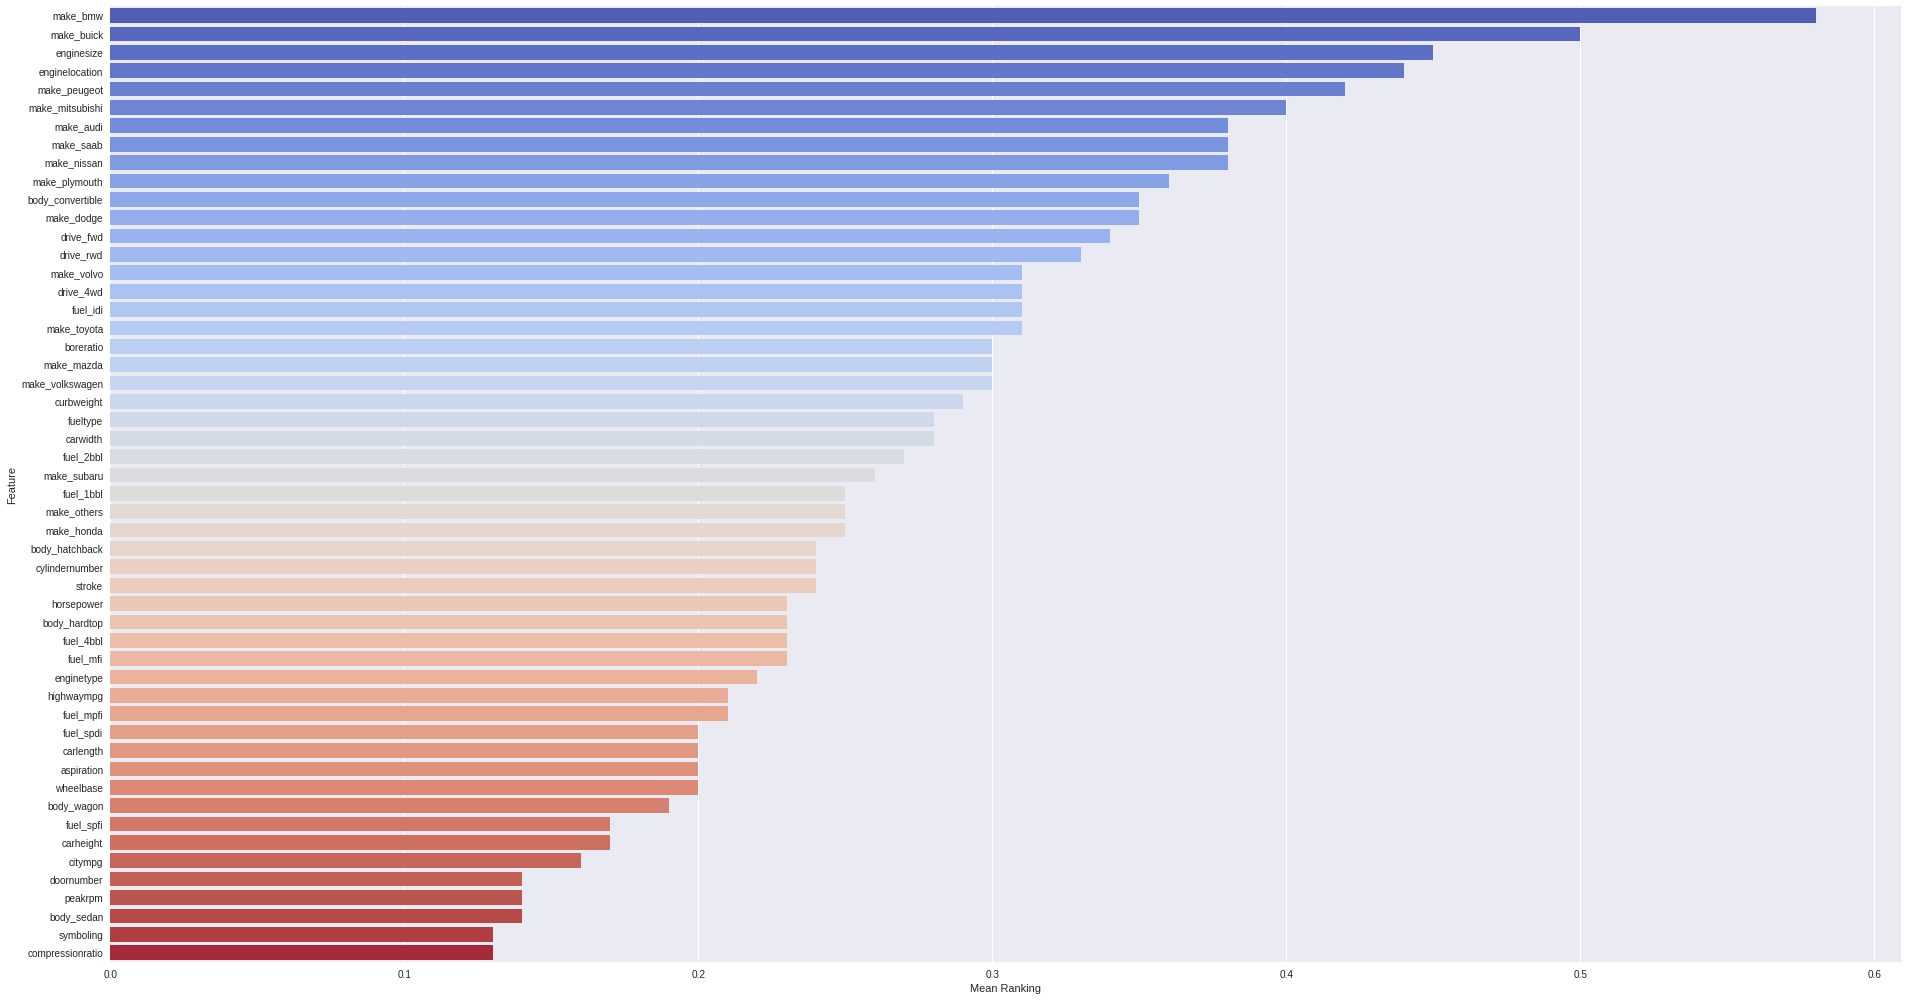

In [33]:
sns.factorplot(x="Mean Ranking", y="Feature", data = mean_plot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

### Well as you can see from our feature ranking endeavours, the top 3 features are 'make_bmw', 'make_buick', 'enginesize'. The bottom 3 also contribute more than 0.1 so none of the features are to be eliminated.

In [34]:
# Create linear regression object
linreg = LinearRegression()

# Train the model using the training sets
linreg.fit(X,Y)

print "Linear model: ", pretty_print_linear(linreg.coef_, names, sort = True)

# Predict the values using the model
Y_lin_predict = linreg.predict(X)

# Print the root mean square error 
print "Root Mean Square Error: ", root_mean_square_error(Y_lin_predict,Y)

Linear model:  14196.006 * enginelocation + 8637.785 * make_bmw + -6040.116 * make_peugeot + 4483.034 * make_buick + -3648.58 * enginetype + -3641.011 * boreratio + -3550.487 * make_mitsubishi + 3261.03 * make_saab + 3201.856 * body_convertible + -2954.228 * make_plymouth + 2859.802 * fuel_idi + -2859.802 * fueltype + -2708.904 * make_dodge + -1482.48 * make_nissan + -1475.608 * fuel_mfi + -1381.386 * fuel_1bbl + -1372.737 * body_hatchback + 1199.248 * aspiration + 1195.294 * make_audi + -1181.128 * stroke + 1037.747 * fuel_2bbl + -976.352 * make_toyota + -924.05 * cylindernumber + -911.258 * fuel_4bbl + 846.761 * carwidth + -640.425 * body_wagon + -601.692 * body_hardtop + -587.002 * body_sedan + 551.904 * make_volvo + 517.636 * fuel_spfi + -447.046 * fuel_mpfi + -432.001 * drive_fwd + -417.774 * compressionratio + -385.144 * make_others + 315.263 * drive_4wd + 259.352 * wheelbase + -251.104 * carheight + -199.887 * fuel_spdi + 185.559 * highwaympg + 139.769 * doornumber + -139.071 * 

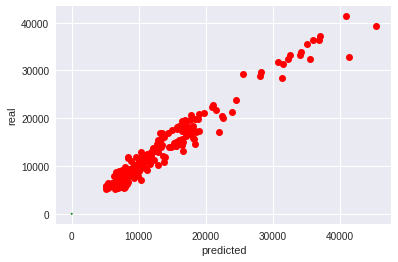

<module 'matplotlib.pyplot' from '/home/bhavesh/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [35]:
plot_real_vs_predicted(Y,Y_lin_predict)